In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

In [34]:
data = pd.read_excel("Test11.xls", keep_default_na=False)

In [35]:
water = np.array(data["Tacqua"])
salt = np.array(data["Salinita"])
air = np.array(data["Taria"])
atm = np.array(data["Patm"])


In [36]:
columns_to_normalize_standard = ['Tacqua', 'Salinita', 'Taria', 'Patm']
scaler_standard = StandardScaler()
water = scaler_standard.fit_transform(water.reshape(-1, 1)).flatten()
salt = scaler_standard.fit_transform(salt.reshape(-1, 1)).flatten()
air = scaler_standard.fit_transform(air.reshape(-1, 1)).flatten()
atm = scaler_standard.fit_transform(atm.reshape(-1, 1)).flatten()



categorical = np.array(data[["StazCamp"]])

In [37]:
conc_norm = np.log10(np.array(data["Conc"]) + 1.01)
b_20 = conc_norm / 20

In [38]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categorical)
encodings = enc.transform(categorical).toarray()

In [39]:
np.random.seed(5000) 

In [40]:
a = np.array([water, salt, air, atm]).T
X_train, X_test, y_train, y_test = train_test_split(a, b_20, test_size=0.2)

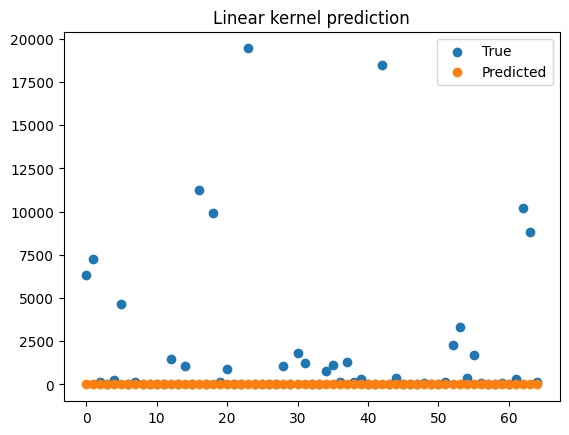

In [41]:
model = KernelRidge(alpha=1e-2, kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Inversione della normalizzazione sulle previsioni
y_pred_orig = (10**(y_pred * 20)) - 1
y_test_orig = (10**(y_test * 20)) - 1

fig, ax = plt.subplots()

y_test_arange = np.arange(len(y_test_orig))

ax.scatter(y_test_arange, y_test_orig, label="True")
ax.scatter(y_test_arange, y_pred_orig, label="Predicted")
ax.legend(loc="best")
plt.title("Linear kernel prediction")
plt.show()

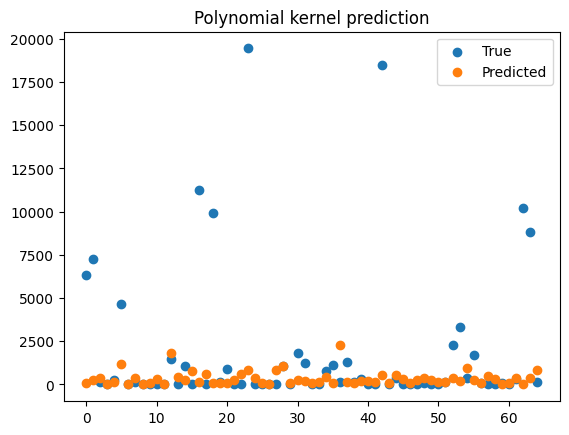

In [42]:
model = KernelRidge(alpha=1e-2, kernel='polynomial', degree=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Inversione della normalizzazione sulle previsioni
y_pred_orig = (10**(y_pred * 20)) - 1
y_test_orig = (10**(y_test * 20)) - 1

fig, ax = plt.subplots()

y_test_arange = np.arange(len(y_test_orig))

ax.scatter(y_test_arange, y_test_orig, label="True")
ax.scatter(y_test_arange, y_pred_orig, label="Predicted")
ax.legend(loc="best")
plt.title("Polynomial kernel prediction")
plt.show()

In [43]:
mse = mean_squared_error(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 18345865.62412271
Mean Absolute Error: 1807.9208363628559


In [44]:
ok = 0

# Risultato in scala logaritmica, moltipicato per 20 per avere il valore originale
# Se la differenza è minore di 1.0 (un ordine di grandezza), considero la previsione corretta 
for i, y in enumerate(y_pred):
    if abs(y - y_test[i]) * 20 < 1.0:
        ok += 1
        
print("Predizioni", y_pred.size)
print("Predizioni accettabili", ok)
print("Accuratezza", ok / y_pred.size *100 , "%")

Predizioni 65
Predizioni accettabili 34
Accuratezza 52.307692307692314 %


In [19]:
# Calcola 4 densità di probabilità della distribuzione normale con media e deviazione standard per ogni feature
# Prodotto di 4 Gaussiane per ottenere nuova distribuzione dei dati
def predict_without_categorical(x1, x2, x3, x4, u1, s1, u2, s2, u3, s3, u4, s4):
    return np.exp(np.power((x1 - u1) / s1, 2) / -2) * np.exp(np.power((x2 - u2) / s2, 2) / -2) \
        * np.exp(np.power((x3 - u3) / s3, 2) / -2) * np.exp(np.power((x4 - u4) / s4, 2) / -2)

# Predizione con variabile categorica (encodings) e pesi
# Usiamo prodottto matriciale e trasposta, moltiplico pesi per ecdoings trasposta
# Ad ogni stazione si associa un peso
def predict(x1, x2, x3, x4, encodings, u1, s1, u2, s2, u3, s3, u4, s4, weights):
    return predict_without_categorical(x1, x2, x3, x4, u1, s1, u2, s2, u3, s3, u4, s4) * (weights @ encodings.T)

# Derivata per la media
def dpdu(x, u, s):
    return -(u - x) / np.power(s, 2) 

# Derivata per la deviazione standard
def dpds(x, u, s):
    return np.power((x - u), 2) / np.power(s, 3) 

# Calcola il gradiente della funzione di errore rispetto a tutti i parametri
# Gradiente è una lista di derivate parziali rispetto a ogni parametro
def gradient(y, x1, x2, x3, x4, encodings, u1, s1, u2, s2, u3, s3, u4, s4, weights):
    
    pred_without_categorical = predict_without_categorical(x1, x2, x3, x4, u1, s1, u2, s2, u3, s3, u4, s4)
    
    pred = predict(x1, x2, x3, x4, encodings, u1, s1, u2, s2, u3, s3, u4, s4, weights)
    
    error = pred - y
    
    # Somma delle derivate è uguale alla derivata della somma
    du1 = np.sum(2 * error * pred * dpdu(x1, u1, s1)) / error.size
    ds1 = np.sum(2 * error * pred * dpds(x1, u1, s1)) / error.size

    du2 = np.sum(2 * error * pred * dpdu(x2, u2, s2)) / error.size
    ds2 = np.sum(2 * error * pred * dpds(x2, u2, s2)) / error.size

    du3 = np.sum(2 * error * pred * dpdu(x3, u3, s3)) / error.size
    ds3 = np.sum(2 * error * pred * dpds(x3, u3, s3)) / error.size

    du4 = np.sum(2 * error * pred * dpdu(x4, u4, s4)) / error.size
    ds4 = np.sum(2 * error * pred * dpds(x4, u4, s4)) / error.size
    
    enc_grad = np.zeros(weights.size)
    
    # Calcolo parte del gradiente relativa ai pesi della variabile categorica
    for i in range(weights.size):
        z = np.zeros(weights.size)
        z[i] = 1
        # Derivate parziali rispetto ai pesi per la variabile categorica
        # z è un vettore di pesi con tutti 0 tranne l'i-esimo che è 1
        enc_grad[i] = np.sum(2 * error * pred_without_categorical * (z @ encodings.T)) / error.size
        # z @ encodings.T moltiplica per 1 se la stazione è quella giusta altrimenti per 0
        
    gradient = np.array([du1, ds1, du2, ds2, du3, ds3, du4, ds4])
    
    return gradient, enc_grad
    
    

In [20]:
# Train test split

# Crea un array di indici da 0 a water.size - 1.
perm = np.arange(water.size)
# Mescola l'array di indici.
np.random.shuffle(perm)

# Applicazione della permutazione
water = water[perm]
salt = salt[perm]
air = air[perm]
atm = atm[perm]
encodings = encodings[perm]
b_20 = b_20[perm]


In [21]:
# Così si parte con le normali
u1 = 0
s1 = 1
u2 = 0
s2 = 1
u3 = 0
s3 = 1
u4 = 0
s4 = 1

# I pesi partono come serie di 1 
weights = np.ones(encodings.shape[1])

encs = encodings[:240] #np.zeros((200,encodings.shape[1]))

x1 = water[:240]
x2 = salt[:240]
x3 = air[:240]
x4 = atm[:240]
y = b_20[:240]

for t in range(1, 10000):
    # gradient descent
    step = 20 / (t**0.1) # step chosen "randomly"
    # Serve per per vedere se converge
    loss = np.power(predict(x1, x2, x3, x4, encs, u1, s1, u2, s2, u3, s3, u4, s4, weights) - y, 2)
    loss = np.sum(loss) / loss.size # normalize loss
    if t % 500 == 0:
        print(f"loss: {loss}") # debug print
    # Gradiente, w_grad contiene la parte degli encodings
    grad, w_grad = gradient(y, x1, x2, x3, x4, encs, u1, s1, u2, s2, u3, s3, u4, s4, weights)

    u1 = u1 - step * grad[0]
    s1 = s1 - step * grad[1]
    u2 = u2 - step * grad[2]
    s2 = s2 - step * grad[3]
    u3 = u3 - step * grad[4]
    s3 = s3 - step * grad[5]
    u4 = u4 - step * grad[6]
    s4 = s4 - step * grad[7]
    weights = weights - step * w_grad
    if loss < 0.0022:
        break
    
print(u1, s1, u2, s2, u3, s3, u4, s4)
    

loss: 0.0025509209676888808
loss: 0.0024549710898992497
loss: 0.002424874533078396
loss: 0.0024095187592027404
loss: 0.0023998326853642486
loss: 0.002393005878151487
loss: 0.0023878558409324816
loss: 0.002383787838523747
loss: 0.002380465954077192
loss: 0.0023776842941909257
loss: 0.0023753087273554554
loss: 0.002373247634262033
loss: 0.0023714360157171066
loss: 0.002369826303670772
loss: 0.0023683827731433896
loss: 0.0023670779987869386
loss: 0.0023658905271973546
loss: 0.0023648033009063393
loss: 0.0023638025629859182
1.7873592333311594 -2.5814293379346807 -0.9505845404241542 2.14895921193672 0.6308574335182875 -2.975070347759313 2.3832776058989036 -5.272013944784104


In [22]:
xx1 = water[240:]
xx2 = salt[240:]
xx3 = air[240:]
xx4 = atm[240:]
yy = b_20[240:]
encs2 = encodings[240:]

loss = np.power(predict(xx1, xx2, xx3, xx4, encs2, u1, s1, u2, s2, u3, s3, u4, s4, weights) - yy, 2)
loss = np.sum(loss) / loss.size

print("Errore", 20 * loss)
# 1/20 di ordine di grandezza come errore

Errore 0.0501276854912466


In [23]:
y_pred = predict(xx1, xx2, xx3, xx4, encs2, u1, s1, u2, s2, u3, s3, u4, s4, weights)

ok = 0

for i, y in enumerate(y_pred):
    if abs(y - yy[i]) * 20 < 1.0:
        ok += 1
        
print("Predizioni", y_pred.size)
print("Predizioni accettabili", ok)
print("Accuratezza", ok / y_pred.size *100 , "%")


Predizioni 81
Predizioni accettabili 60
Accuratezza 74.07407407407408 %


In [24]:
# In alcune stazioni l'alga nasce più facilmente, in altre meno
print(weights)

[0.12095544 0.25944214 0.23306617 0.23399808 0.21668499 0.22784112
 0.07691828 0.24966327 0.1681535  0.28978361 0.14078123 0.13556298
 0.27044417 0.22173698 0.17013735 0.27734907]


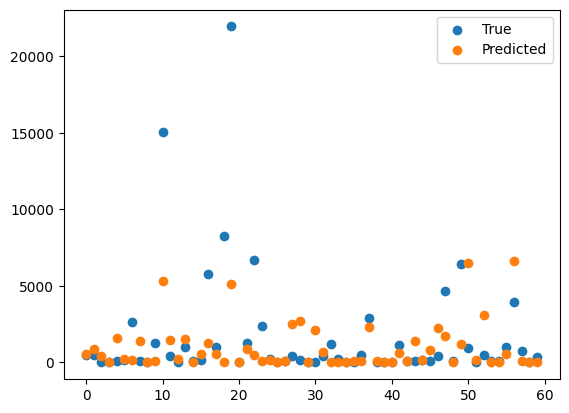

In [25]:
xs = np.arange(60)
fig, ax = plt.subplots()
ax.scatter(xs, 10**(yy[10:70] * 20), label="True")
ax.scatter(xs, 10**(y_pred[10:70] * 20), label="Predicted")
plt.legend()
plt.show()

In [26]:
# Rimuovo la variabile categorica per fare il resampling
data.drop('StazCamp', axis=1, inplace=True)

In [27]:
def gradient_without_categorical(y, x1, x2, x3, x4, u1, s1, u2, s2, u3, s3, u4, s4):
    
    pred_without_categorical = predict_without_categorical(x1, x2, x3, x4, u1, s1, u2, s2, u3, s3, u4, s4)
    
    error = pred_without_categorical - y
    
    # Somma delle derivate è uguale alla derivata della somma
    du1 = np.sum(2 * error * pred_without_categorical * dpdu(x1, u1, s1)) / error.size
    ds1 = np.sum(2 * error * pred_without_categorical * dpds(x1, u1, s1)) / error.size

    du2 = np.sum(2 * error * pred_without_categorical * dpdu(x2, u2, s2)) / error.size
    ds2 = np.sum(2 * error * pred_without_categorical * dpds(x2, u2, s2)) / error.size

    du3 = np.sum(2 * error * pred_without_categorical * dpdu(x3, u3, s3)) / error.size
    ds3 = np.sum(2 * error * pred_without_categorical * dpds(x3, u3, s3)) / error.size

    du4 = np.sum(2 * error * pred_without_categorical * dpdu(x4, u4, s4)) / error.size
    ds4 = np.sum(2 * error * pred_without_categorical * dpds(x4, u4, s4)) / error.size

    gradient = np.array([du1, ds1, du2, ds2, du3, ds3, du4, ds4])
    
    return gradient

In [28]:
# Così si parte con le normali
u1 = 0
s1 = 1
u2 = 0
s2 = 1
u3 = 0
s3 = 1
u4 = 0
s4 = 1

x1 = water[:240]
x2 = salt[:240]
x3 = air[:240]
x4 = atm[:240]
y = b_20[:240]

for t in range(1, 20000):
    # gradient descent
    step = 20 / (t**0.1) # step chosen "randomly"
    # Serve per per vedere se converge
    loss = np.power(predict_without_categorical(x1, x2, x3, x4, u1, s1, u2, s2, u3, s3, u4, s4) - y, 2)
    loss = np.sum(loss) / loss.size # normalize loss
    if t % 500 == 0:
        print(f"loss: {loss}") # debug print
    # Gradiente, w_grad contiene la parte degli encodings
    grad = gradient_without_categorical(y, x1, x2, x3, x4, u1, s1, u2, s2, u3, s3, u4, s4)
    # w_grad is the gradient for the categorical vars, as concatenating 2 and then splitting 2 numpy arrays was annoying
    # Si aggiorna il valore di ciascun parametro con l'opposto del gradiente moltiplicato per lo step
    # Perchè il gradiente è la direzione dove il loss aumenta maggiormente, quindi si va nella direzione opposta
    # Per minimizzare la funzione di errore (loss)
    # Ciò si fa moltiplicando per lo step
    u1 = u1 - step * grad[0]
    s1 = s1 - step * grad[1]
    u2 = u2 - step * grad[2]
    s2 = s2 - step * grad[3]
    u3 = u3 - step * grad[4]
    s3 = s3 - step * grad[5]
    u4 = u4 - step * grad[6]
    s4 = s4 - step * grad[7]
    
    if loss < 0.0022:
        break
    
print(u1, s1, u2, s2, u3, s3, u4, s4)

loss: 0.004735010380532331
loss: 0.0043088820239039535
loss: 0.004120266772419588
loss: 0.004003471912052505
loss: 0.003921090698772356
loss: 0.003858192583055039
loss: 0.0038074687537145964
loss: 0.0037648972849445377
loss: 0.003728131798397779
loss: 0.003695816700753762
loss: 0.0036672619247702476
loss: 0.003642233261007532
loss: 0.003620722294291127
loss: 0.0036026673362291187
loss: 0.0035877454446023344
loss: 0.003575384949108068
loss: 0.0035649548875613295
loss: 0.0035559355189787333
loss: 0.003547967267957167
loss: 0.0035408186506733874
loss: 0.003534338877060661
loss: 0.003528423531285933
loss: 0.0035229949842263005
loss: 0.0035179921423342015
loss: 0.003513365063720561
loss: 0.0035090719426757316
loss: 0.003505077253276637
loss: 0.0035013504947830603
loss: 0.0034978652796367805
loss: 0.0034945986369015617
loss: 0.003491530463192261
loss: 0.003488643081011629
loss: 0.0034859208785863265
loss: 0.0034833500132104133
loss: 0.0034809181649590576
loss: 0.003478614330854259
loss: 0.00

In [29]:
xx1 = water[240:]
xx2 = salt[240:]
xx3 = air[240:]
xx4 = atm[240:]
yy = b_20[240:]

loss = np.power(predict_without_categorical(xx1, xx2, xx3, xx4, u1, s1, u2, s2, u3, s3, u4, s4) - yy, 2)
loss = np.sum(loss) / loss.size

print("Errore: ", 20 * loss)
# 1/20 di ordine di grandezza come errore

Errore:  0.07018992874622593


In [30]:
y_pred = predict_without_categorical(xx1, xx2, xx3, xx4, u1, s1, u2, s2, u3, s3, u4, s4)

ok = 0

for i, y in enumerate(y_pred):
    if abs(y - yy[i]) * 20 < 1.0:
        ok += 1
        
print("Predizioni", y_pred.size)
print("Predizioni accettabili",ok)
print("Accuratezza", ok / y_pred.size * 100, "%")

Predizioni 81
Predizioni accettabili 50
Accuratezza 61.72839506172839 %


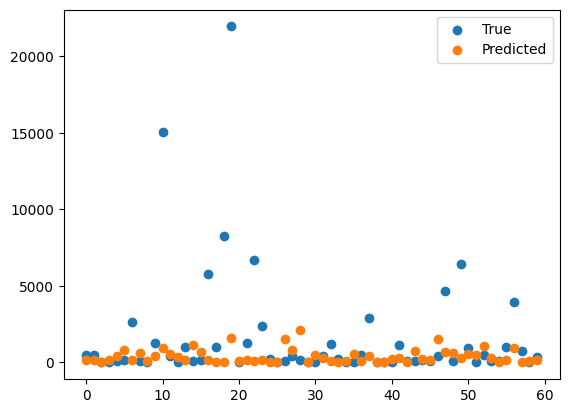

In [31]:
xs = np.arange(60)
fig, ax = plt.subplots()
ax.scatter(xs, 10**(yy[10:70] * 20), label="True")
ax.scatter(xs, 10**(y_pred[10:70] * 20), label="Predicted")
plt.legend()
plt.show()